In [287]:
import tensorflow
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

In [288]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**미국 주식 데이터(대회 제공) 불러오기**

In [289]:
ifo = pd.read_csv("/content/drive/MyDrive/NH빅데이터/dataset/NASDAQ_FC_STK_IEM_IFO.csv", encoding = 'cp949')
ifo

,isin_cd,tck_iem_cd,fc_sec_krl_nm,fc_sec_eng_nm
0,US00211V1061,AACG,ATA ...,ATA CreatGlo ...
1,US00032Q1040,AADI,Aadi Bioscience ...,Aadi Bioscience ...
2,US02376R1023,AAL,아메리칸 에어라인스 그룹 ...,American Airline ...
3,US03823U1025,AAOI,어플라이드 옵토일렉트로닉스 ...,AOI ...
4,US0003602069,AAON,에이에이온 ...,AAON ...
...,...,...,...,...
2738,US4884452065,ZVRA,Zevra ...,Zevra ...
2739,US98987D1028,ZVSA,Zyversa ...,Zyversa ...
2740,US98985Y1082,ZYME,Zymeworks ...,Zymeworks ...
2741,US98986X1090,ZYNE,자이너바 파마수티컬스 ...,Zynerba Pharms ...


In [290]:
#ticker 코드 끝에 들어가있는 \t 개행문자 제거
ifo['tck_iem_cd'] =ifo['tck_iem_cd'].str.rstrip()
ifo['tck_iem_cd']

0       AACG
1       AADI
2        AAL
3       AAOI
4       AAON
        ... 
2738    ZVRA
2739    ZVSA
2740    ZYME
2741    ZYNE
2742    ZYXI
Name: tck_iem_cd, Length: 2743, dtype: object

**미국 주식의 sector 이용하기 위해 외부 데이터셋 불러옴.**

In [291]:
scr = pd.read_csv("/content/drive/MyDrive/NH빅데이터/dataset/NASDAQ_SCREENER.csv")
scr

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$110.64,0.2900,0.263%,3.237186e+10,United States,1999.0,1796054,Industrials,Electrical Products
1,AA,Alcoa Corporation Common Stock,$27.15,0.6200,2.337%,4.844907e+09,United States,2016.0,6242474,Industrials,Aluminum
2,AAC,Ares Acquisition Corporation Class A Ordinary ...,$10.76,0.0150,0.14%,7.597018e+08,NaN,2021.0,1347586,Industrials,Metal Fabrications
3,AACG,ATA Creativity Global American Depositary Shares,$1.10,0.0000,0.00%,3.478439e+07,China,2008.0,3847,Consumer Discretionary,Educational Services
4,AACI,Armada Acquisition Corp. I Common Stock,$10.76,0.0000,0.00%,0.000000e+00,United States,2021.0,7,Finance,Blank Checks
...,...,...,...,...,...,...,...,...,...,...,...
7510,ZVSA,ZyVersa Therapeutics Inc. Common Stock,$0.12,-0.0107,-8.187%,3.707303e+06,United States,2022.0,5277753,Health Care,Biotechnology: Pharmaceutical Preparations
7511,ZWS,Zurn Elkay Water Solutions Corporation Common ...,$26.46,-0.6000,-2.217%,4.576198e+09,United States,2012.0,2216283,Industrials,Industrial Machinery/Components
7512,ZYME,Zymeworks Inc. Common Stock,$6.40,0.1400,2.236%,4.340908e+08,United States,NaN,336159,Health Care,Biotechnology: Pharmaceutical Preparations
7513,ZYNE,Zynerba Pharmaceuticals Inc. Common Stock,$1.28,0.0300,2.40%,6.904247e+07,United States,2015.0,380050,Health Care,Biotechnology: Pharmaceutical Preparations


**위에서 불러온 외부 데이터 가공**

In [292]:
scr.isnull().sum()

Symbol           1
Name             0
Last Sale        0
Net Change       0
% Change         2
Market Cap     433
Country        407
IPO Year      3157
Volume           0
Sector         657
Industry       657
dtype: int64

In [293]:
scr.dropna(subset=['Sector'], inplace=True)

In [294]:
scr = scr[scr['Country']=='United States']

In [295]:
len(set(scr['Sector']))

12

In [296]:
pairs = pd.concat([scr['Sector'], scr['Symbol']], axis=1)
print(pairs)

           Sector Symbol
0     Industrials      A
1     Industrials     AA
4         Finance   AACI
5         Finance  AACIU
6         Finance  AACIW
...           ...    ...
7510  Health Care   ZVSA
7511  Industrials    ZWS
7512  Health Care   ZYME
7513  Health Care   ZYNE
7514  Health Care   ZYXI

[5333 rows x 2 columns]


In [297]:
ifo = pd.merge(ifo,pairs,left_on='tck_iem_cd', right_on='Symbol', how='inner')
ifo

,isin_cd,tck_iem_cd,fc_sec_krl_nm,fc_sec_eng_nm,Sector,Symbol
0,US00032Q1040,AADI,Aadi Bioscience ...,Aadi Bioscience ...,Health Care,AADI
1,US02376R1023,AAL,아메리칸 에어라인스 그룹 ...,American Airline ...,Consumer Discretionary,AAL
2,US03823U1025,AAOI,어플라이드 옵토일렉트로닉스 ...,AOI ...,Technology,AAOI
3,US0003602069,AAON,에이에이온 ...,AAON ...,Industrials,AAON
4,US0378331005,AAPL,애플 ...,Apple ...,Technology,AAPL
...,...,...,...,...,...,...
2148,US4884452065,ZVRA,Zevra ...,Zevra ...,Health Care,ZVRA
2149,US98987D1028,ZVSA,Zyversa ...,Zyversa ...,Health Care,ZVSA
2150,US98985Y1082,ZYME,Zymeworks ...,Zymeworks ...,Health Care,ZYME
2151,US98986X1090,ZYNE,자이너바 파마수티컬스 ...,Zynerba Pharms ...,Health Care,ZYNE


In [298]:
ifo.isnull().sum()

isin_cd          0
tck_iem_cd       0
fc_sec_krl_nm    0
fc_sec_eng_nm    0
Sector           0
Symbol           0
dtype: int64

In [299]:
ifo = ifo.drop(['Symbol'],axis=1)

In [300]:
ifo['Sector'].value_counts()

Health Care               715
Technology                369
Consumer Discretionary    350
Finance                   343
Industrials               156
Consumer Staples           49
Real Estate                40
Telecommunications         38
Utilities                  34
Energy                     33
Miscellaneous              21
Basic Materials             5
Name: Sector, dtype: int64

**1월부터 8월까지의 NASDAQ 데이터 불러옴**

In [301]:
qut = pd.read_csv("/content/drive/MyDrive/NH빅데이터/dataset/NASDAQ_DT_FC_STK_QUT.csv", encoding = 'cp949')

In [302]:
#sector 데이터와 8개월간의 주식 가격 데이터 병합
qut = pd.merge(ifo,qut, on='tck_iem_cd', how='inner')
qut['trd_dt'] = qut['trd_dt'].astype('str')
qut['trd_dt'] = pd.to_datetime(qut['trd_dt'])
qut['trd_dt']

0        2023-01-03
1        2023-01-04
2        2023-01-05
3        2023-01-06
4        2023-01-09
            ...    
357393   2023-08-24
357394   2023-08-25
357395   2023-08-28
357396   2023-08-29
357397   2023-08-30
Name: trd_dt, Length: 357398, dtype: datetime64[ns]

In [303]:
qut

,isin_cd,tck_iem_cd,fc_sec_krl_nm,fc_sec_eng_nm,Sector,trd_dt,gts_iem_ong_pr,gts_iem_hi_pr,gts_iem_low_pr,gts_iem_end_pr,gts_acl_trd_qty,gts_sll_cns_sum_qty,gts_byn_cns_sum_qty
0,US00032Q1040,AADI,Aadi Bioscience ...,Aadi Bioscience ...,Health Care,2023-01-03,12.910,13.090,12.270,12.31,75641.0,35560.0,40081.0
1,US00032Q1040,AADI,Aadi Bioscience ...,Aadi Bioscience ...,Health Care,2023-01-04,12.355,12.710,12.335,12.67,57841.0,32365.0,25476.0
2,US00032Q1040,AADI,Aadi Bioscience ...,Aadi Bioscience ...,Health Care,2023-01-05,12.700,12.945,12.500,12.52,49288.0,26353.0,22935.0
3,US00032Q1040,AADI,Aadi Bioscience ...,Aadi Bioscience ...,Health Care,2023-01-06,12.620,12.990,12.440,12.49,205996.0,174026.0,31970.0
4,US00032Q1040,AADI,Aadi Bioscience ...,Aadi Bioscience ...,Health Care,2023-01-09,12.630,12.970,12.110,12.13,90661.0,61704.0,28957.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
357393,US98986M1036,ZYXI,Zynex ...,Zynex ...,Health Care,2023-08-24,8.020,8.020,7.650,7.75,268578.0,170630.0,97948.0
357394,US98986M1036,ZYXI,Zynex ...,Zynex ...,Health Care,2023-08-25,7.740,7.770,7.510,7.70,179197.0,81549.0,97648.0
357395,US98986M1036,ZYXI,Zynex ...,Zynex ...,Health Care,2023-08-28,7.700,7.770,7.570,7.66,200784.0,104724.0,96060.0
357396,US98986M1036,ZYXI,Zynex ...,Zynex ...,Health Care,2023-08-29,7.650,7.740,7.550,7.71,247955.0,124040.0,123915.0


**ANN에 이용할 통계적 지표 계산 및 시각화**

In [304]:
#일별 수익률
qut['daily_return'] = qut['gts_iem_end_pr'].pct_change()
window_size = 20
#moving average
qut['SMA'] = qut['gts_iem_end_pr'].rolling(window=window_size).mean()
qut['VLT_SD'] = qut['daily_return'].rolling(window=window_size).std()

In [305]:
#ATR
window_atr = 14
qut['TR'] = abs(qut['gts_iem_hi_pr'] - qut['gts_iem_low_pr'])
qut['TR_MA'] = qut['TR'].rolling(window=window_atr).mean()
qut['ATR'] = qut['TR_MA'].rolling(window=window_atr).mean()

#MACD
window_short = 12
window_long = 26
signal_window = 9
qut['EMA_Short'] = qut['gts_iem_end_pr'].ewm(span=window_short).mean()
qut['EMA_Long'] = qut['gts_iem_end_pr'].ewm(span=window_long).mean()
qut['MACD'] = qut['EMA_Short'] - qut['EMA_Long']
qut['Signal_Line'] = qut['MACD'].ewm(span=signal_window).mean()

#RSI
window_rsi = 14  # RSI window
delta = qut['daily_return'].fillna(0)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=window_rsi).mean()
avg_loss = loss.rolling(window=window_rsi).mean()
rs = avg_gain / avg_loss
qut['RSI'] = 100 - (100 / (1 + rs))

#Bollinger Bands
sigma = 2
qut['Upper_Band'] = qut['SMA'] + (sigma * qut['VLT_SD'])
qut['Lower_Band'] = qut['SMA'] - (sigma * qut['VLT_SD'])

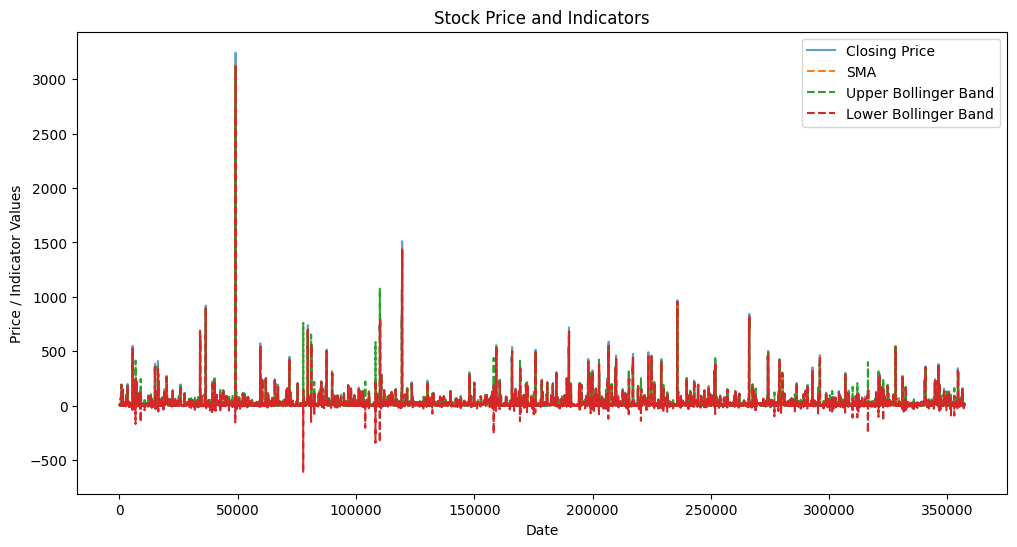

In [306]:
plt.figure(figsize=(12, 6))
plt.plot(qut['gts_iem_end_pr'], label='Closing Price', alpha=0.7)
plt.plot(qut['SMA'], label='SMA', linestyle='--')
plt.plot(qut['Upper_Band'], label='Upper Bollinger Band', linestyle='--')
plt.plot(qut['Lower_Band'], label='Lower Bollinger Band', linestyle='--')
plt.title('Stock Price and Indicators')
plt.xlabel('Date')
plt.ylabel('Price / Indicator Values')
plt.legend()
plt.show()

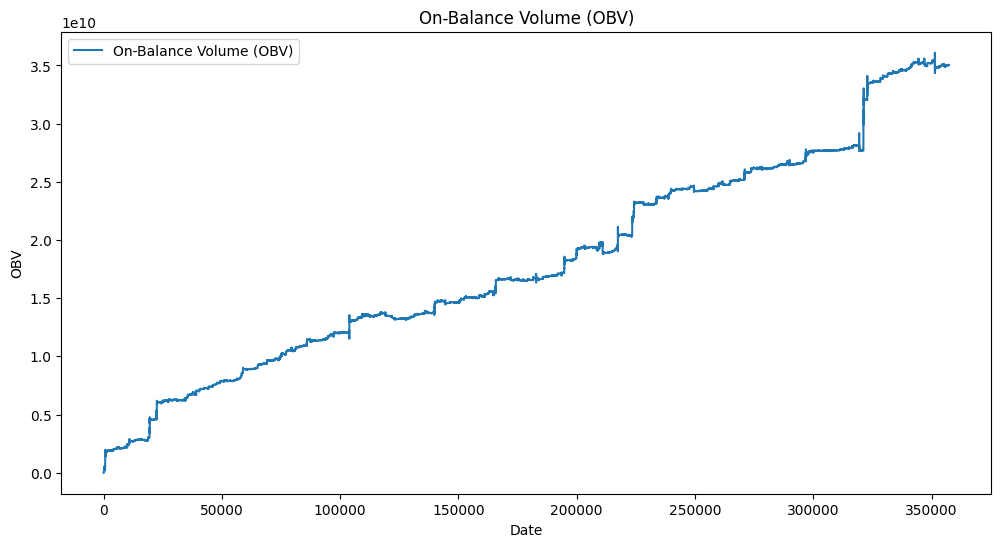

In [307]:
#On-Balance Volumn
qut['OBV'] = 0
qut.loc[qut['daily_return'] > 0, 'OBV'] = qut['gts_acl_trd_qty']
qut.loc[qut['daily_return'] < 0, 'OBV'] = -qut['gts_acl_trd_qty']
qut['OBV'] = qut['OBV'].cumsum()

#plotting OBV
plt.figure(figsize=(12, 6))
plt.plot(qut.index, qut['OBV'], label='On-Balance Volume (OBV)')
plt.title('On-Balance Volume (OBV)')
plt.xlabel('Date')
plt.ylabel('OBV')
plt.legend()
plt.show()

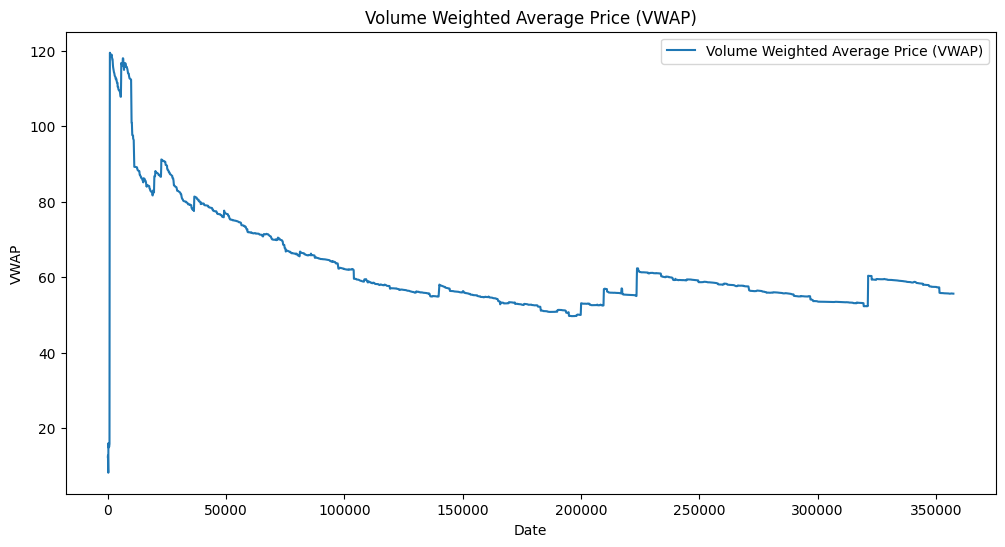

In [308]:
#VWAP
qut['VWAP'] = (qut['gts_iem_end_pr'] * qut['gts_acl_trd_qty']).cumsum() / qut['gts_acl_trd_qty'].cumsum()

#Plotting
plt.figure(figsize=(12, 6))
plt.plot(qut.index, qut['VWAP'], label='Volume Weighted Average Price (VWAP)')
plt.title('Volume Weighted Average Price (VWAP)')
plt.xlabel('Date')
plt.ylabel('VWAP')
plt.legend()
plt.show()

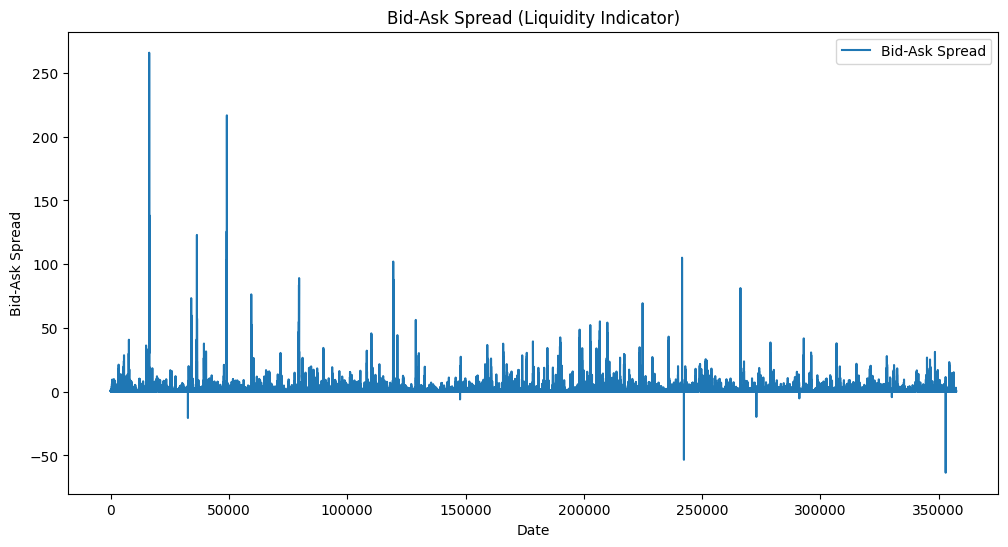

In [309]:
#Bid-Ask Spread
qut['Bid_Ask_Spread'] = qut['gts_iem_hi_pr'] - qut['gts_iem_low_pr']

# Plotting Bid-Ask Spread
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(qut.index, qut['Bid_Ask_Spread'], label='Bid-Ask Spread')
plt.title('Bid-Ask Spread (Liquidity Indicator)')
plt.xlabel('Date')
plt.ylabel('Bid-Ask Spread')
plt.legend()
plt.show()

In [310]:
#Value at Risk
alpha = 0.05
returns = qut['daily_return'].dropna()
var = np.percentile(returns, alpha * 100)
print(f"Historical VaR ({alpha*100}% confidence level): {var:.2f}")
cvar = returns[returns <= var].mean()
print(f"Conditional VaR ({alpha*100}% confidence level): {cvar:.2f}")

Historical VaR (5.0% confidence level): -0.06
Conditional VaR (5.0% confidence level): -0.14


**한국 주식의 업종이 나와있는 데이터 불러오기**

In [311]:
kifo = pd.read_csv("/content/drive/MyDrive/NH빅데이터/dataset/KOSDAQ_IFO.csv", encoding='cp949')
kifo

,종목코드,종목명,시장구분,업종명,종가,대비,등락률,시가총액
0,060310,3S,KOSDAQ,기계·장비,2655,-45,-1.67,128864784510
1,054620,APS,KOSDAQ,금융,8380,-170,-1.99,170903571980
2,265520,AP시스템,KOSDAQ,반도체,18270,-50,-0.27,279191561670
3,211270,AP위성,KOSDAQ,통신장비,13030,130,1.01,196522421120
4,126600,BGF에코머티리얼즈,KOSDAQ,화학,5100,-30,-0.58,275569702500
...,...,...,...,...,...,...,...,...
1665,024060,흥구석유,KOSDAQ,유통,5010,-100,-1.96,75150000000
1666,010240,흥국,KOSDAQ,기계·장비,6210,-90,-1.43,76523942160
1667,189980,흥국에프엔비,KOSDAQ,음식료·담배,2460,-40,-1.60,98739054420
1668,037440,희림,KOSDAQ,기타서비스,6680,-30,-0.45,93002133000


KRX 정보데이터시스템에서 1월 3일부터 8월 30일까지의 주식 시세 데이터 다운로드 (웹 크롤링 이용)  
해당 부분은 local 환경에서 진행함. (jupyter notebook) 다운로드하여 병합한 파일을 KOSDAQ_QUT로 저장.

In [312]:
kqut = pd.read_csv("/content/drive/MyDrive/NH빅데이터/dataset/KOSDAQ_QUT.csv", encoding = 'euc-kr')
#kqut = kqut[kqut['시장구분']=='KOSDAQ']
kqut.rename(columns={'0':'종목코드', '1':'종목명','2':'시장구분','3':'소속부','4':'종가','5':'대비','6':'등락률','7':'시가','8':'고가','9':'저가','10':'거래량','11':'거래대금','12':'시가총액','13':
                     '상장주식수', '14':'날짜'}, inplace=True)

In [313]:
kqut=kqut[kqut['시장구분']=='KOSDAQ']

In [314]:
kqut=kqut[kqut['시장구분']=='KOSDAQ']
kqut.drop(['시장구분', '소속부'], axis=1, inplace=True)

In [315]:
kqut

,종목코드,종목명,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,날짜
0,060310,3S,2010.0,-10.0,-0.50,2000.0,2045.0,1930.0,316570.0,6.310404e+08,9.755865e+10,48536642.0,20230103.0
3,054620,APS홀딩스,14150.0,-950.0,-6.29,15100.0,15300.0,13850.0,402038.0,5.742561e+09,2.885782e+11,20394221.0,20230103.0
4,265520,AP시스템,17700.0,-100.0,-0.56,17750.0,18000.0,17250.0,46927.0,8.250059e+08,2.704812e+11,15281421.0,20230103.0
5,211270,AP위성,9500.0,-220.0,-2.26,9700.0,9790.0,9190.0,160321.0,1.510870e+09,1.432819e+11,15082304.0,20230103.0
11,013720,CBI,409.0,-17.0,-3.99,431.0,436.0,401.0,11133100.0,4.563831e+09,1.105693e+11,270340686.0,20230103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298578,024060,흥구석유,5110.0,10.0,0.20,5110.0,5120.0,5070.0,21003.0,1.068706e+08,7.665000e+10,15000000.0,20230830.0
298579,010240,흥국,6300.0,10.0,0.16,6350.0,6380.0,6250.0,20022.0,1.257652e+08,7.763298e+10,12322696.0,20230830.0
298580,189980,흥국에프엔비,2500.0,60.0,2.46,2475.0,2520.0,2445.0,122545.0,3.046807e+08,1.003446e+11,40137827.0,20230830.0
298584,037440,희림,6710.0,-130.0,-1.90,6820.0,6910.0,6690.0,111173.0,7.538006e+08,9.341981e+10,13922475.0,20230830.0


**데이터 가공**

In [316]:
kqut.isnull().sum()

종목코드        0
종목명         0
종가       1585
대비       1587
등락률      1588
시가       1590
고가       1594
저가       1596
거래량      1599
거래대금     1600
시가총액     1604
상장주식수      24
날짜         27
dtype: int64

In [317]:
kqut.dropna(axis=0, inplace=True)

In [318]:
kqut=kqut.astype({ '종가':'int', '대비':'int', '등락률':'float','시가':'int','고가':'int','저가':'int','거래량':'int','거래대금':'int', '시가총액':'int', '상장주식수':'int', '날짜':'int'})

In [319]:
kqut

,종목코드,종목명,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,날짜
0,060310,3S,2010,-10,-0.50,2000,2045,1930,316570,631040415,97558650420,48536642,20230103
3,054620,APS홀딩스,14150,-950,-6.29,15100,15300,13850,402038,5742561100,288578227150,20394221,20230103
4,265520,AP시스템,17700,-100,-0.56,17750,18000,17250,46927,825005900,270481151700,15281421,20230103
5,211270,AP위성,9500,-220,-2.26,9700,9790,9190,160321,1510870170,143281888000,15082304,20230103
11,013720,CBI,409,-17,-3.99,431,436,401,11133100,4563831111,110569340574,270340686,20230103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298578,024060,흥구석유,5110,10,0.20,5110,5120,5070,21003,106870620,76650000000,15000000,20230830
298579,010240,흥국,6300,10,0.16,6350,6380,6250,20022,125765240,77632984800,12322696,20230830
298580,189980,흥국에프엔비,2500,60,2.46,2475,2520,2445,122545,304680725,100344567500,40137827,20230830
298584,037440,희림,6710,-130,-1.90,6820,6910,6690,111173,753800650,93419807250,13922475,20230830


In [320]:
kqut['날짜'] = kqut['날짜'].astype('str')
kqut['날짜'] = pd.to_datetime(kqut['날짜'])

In [321]:
kqut

,종목코드,종목명,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,날짜
0,060310,3S,2010,-10,-0.50,2000,2045,1930,316570,631040415,97558650420,48536642,2023-01-03
3,054620,APS홀딩스,14150,-950,-6.29,15100,15300,13850,402038,5742561100,288578227150,20394221,2023-01-03
4,265520,AP시스템,17700,-100,-0.56,17750,18000,17250,46927,825005900,270481151700,15281421,2023-01-03
5,211270,AP위성,9500,-220,-2.26,9700,9790,9190,160321,1510870170,143281888000,15082304,2023-01-03
11,013720,CBI,409,-17,-3.99,431,436,401,11133100,4563831111,110569340574,270340686,2023-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298578,024060,흥구석유,5110,10,0.20,5110,5120,5070,21003,106870620,76650000000,15000000,2023-08-30
298579,010240,흥국,6300,10,0.16,6350,6380,6250,20022,125765240,77632984800,12322696,2023-08-30
298580,189980,흥국에프엔비,2500,60,2.46,2475,2520,2445,122545,304680725,100344567500,40137827,2023-08-30
298584,037440,희림,6710,-130,-1.90,6820,6910,6690,111173,753800650,93419807250,13922475,2023-08-30


In [322]:
pairs = pd.concat([kifo['종목코드'], kifo['업종명']], axis=1)
pairs

,종목코드,업종명
0,060310,기계·장비
1,054620,금융
2,265520,반도체
3,211270,통신장비
4,126600,화학
...,...,...
1665,024060,유통
1666,010240,기계·장비
1667,189980,음식료·담배
1668,037440,기타서비스


In [323]:
kqut = pd.merge(kqut,pairs, on='종목코드')
kqut

,종목코드,종목명,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,날짜,업종명
0,060310,3S,2010,-10,-0.50,2000,2045,1930,316570,631040415,97558650420,48536642,2023-01-03,기계·장비
1,060310,3S,2125,115,5.72,2025,2140,2000,217247,451482705,103140364250,48536642,2023-01-04,기계·장비
2,060310,3S,2125,115,5.72,2025,2140,2000,217247,451482705,103140364250,48536642,2023-01-05,기계·장비
3,060310,3S,2185,75,3.55,2110,2185,2075,110979,239248090,106052562770,48536642,2023-01-06,기계·장비
4,060310,3S,2240,55,2.52,2195,2270,2195,167917,375109965,108722078080,48536642,2023-01-09,기계·장비
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168801,457940,에스케이증권제10호스팩,2075,5,0.24,2065,2080,2065,42430,87893495,6868250000,3310000,2023-08-30,금융
168802,457390,대신밸런스제15호스팩,2035,35,1.75,2655,3045,2035,61004368,160470203305,14316225000,7035000,2023-08-30,금융
168803,424960,스마트레이더시스템,22100,5090,29.92,18270,22100,18230,18080769,362352434090,327883114000,14836340,2023-08-30,정보기기
168804,418250,시큐레터,32000,1250,4.07,30450,32200,28800,3160253,97250571300,253168672000,7911521,2023-08-30,소프트웨어


**ANN에 이용할 통계적 지표 계산 및 시각화**

In [324]:
#일별 수익률
kqut['daily_return'] = kqut['종가'].pct_change()
window_size = 20
#moving average
kqut['SMA'] = kqut['종가'].rolling(window=window_size).mean()
kqut['VLT_SD'] = kqut['daily_return'].rolling(window=window_size).std()

In [325]:
#ATR
window_atr = 14
kqut['TR'] = abs(kqut['고가'] - kqut['저가'])
kqut['TR_MA'] = kqut['TR'].rolling(window=window_atr).mean()
kqut['ATR'] = kqut['TR_MA'].rolling(window=window_atr).mean()

In [326]:
#MACD
window_short = 12
window_long = 26
signal_window = 9
kqut['EMA_Short'] = kqut['종가'].ewm(span=window_short).mean()
kqut['EMA_Long'] = kqut['종가'].ewm(span=window_long).mean()
kqut['MACD'] = kqut['EMA_Short'] - kqut['EMA_Long']
kqut['Signal_Line'] = kqut['MACD'].ewm(span=signal_window).mean()

#RSI
window_rsi = 14  # RSI window
delta = kqut['daily_return'].fillna(0)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=window_rsi).mean()
avg_loss = loss.rolling(window=window_rsi).mean()
rs = avg_gain / avg_loss
kqut['RSI'] = 100 - (100 / (1 + rs))

#Bollinger Bands
sigma = 2
kqut['Upper_Band'] = kqut['SMA'] + (sigma * kqut['VLT_SD'])
kqut['Lower_Band'] = kqut['SMA'] - (sigma * kqut['VLT_SD'])

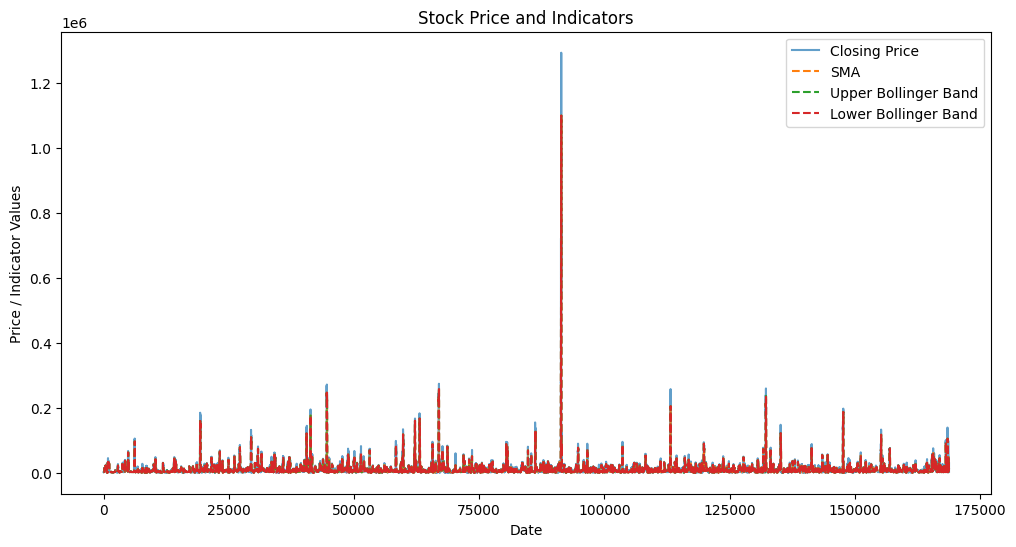

In [327]:
plt.figure(figsize=(12, 6))
plt.plot(kqut['종가'], label='Closing Price', alpha=0.7)
plt.plot(kqut['SMA'], label='SMA', linestyle='--')
plt.plot(kqut['Upper_Band'], label='Upper Bollinger Band', linestyle='--')
plt.plot(kqut['Lower_Band'], label='Lower Bollinger Band', linestyle='--')
plt.title('Stock Price and Indicators')
plt.xlabel('Date')
plt.ylabel('Price / Indicator Values')
plt.legend()
plt.show()

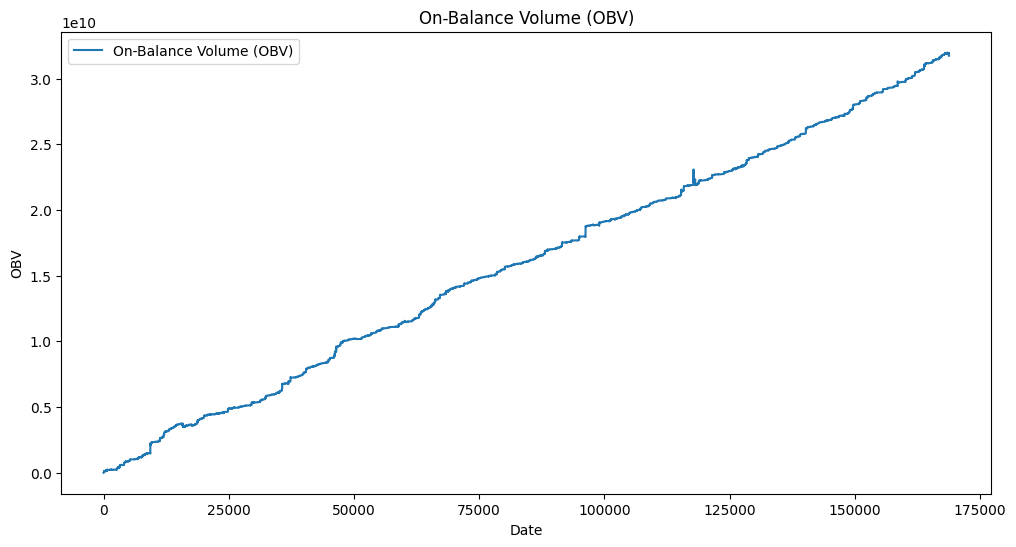

In [328]:
#On-Balance Volumn
kqut['OBV'] = 0
kqut.loc[kqut['daily_return'] > 0, 'OBV'] = kqut['거래량']
kqut.loc[kqut['daily_return'] < 0, 'OBV'] = -kqut['거래량']
kqut['OBV'] = kqut['OBV'].cumsum()

#plotting OBV
plt.figure(figsize=(12, 6))
plt.plot(kqut.index, kqut['OBV'], label='On-Balance Volume (OBV)')
plt.title('On-Balance Volume (OBV)')
plt.xlabel('Date')
plt.ylabel('OBV')
plt.legend()
plt.show()

In [329]:
kqut['OBV'].isnull().sum()

0

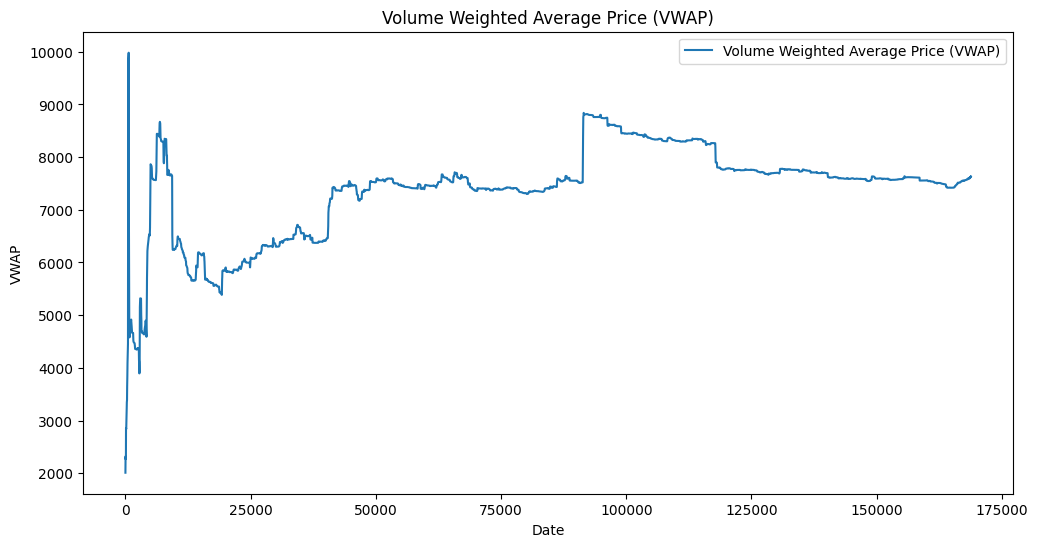

In [330]:
#VWAP
kqut['VWAP'] = (kqut['종가'] * kqut['거래량']).cumsum() / kqut['거래량'].cumsum()

#Plotting
plt.figure(figsize=(12, 6))
plt.plot(kqut.index, kqut['VWAP'], label='Volume Weighted Average Price (VWAP)')
plt.title('Volume Weighted Average Price (VWAP)')
plt.xlabel('Date')
plt.ylabel('VWAP')
plt.legend()
plt.show()

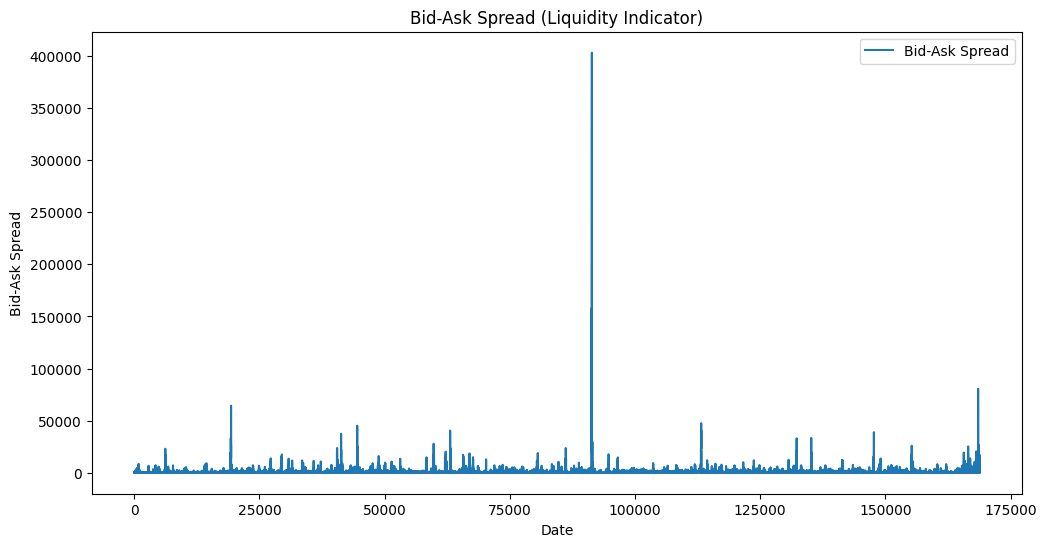

In [331]:
#Bid-Ask Spread
kqut['Bid_Ask_Spread'] = kqut['고가'] - kqut['저가']

# Plotting Bid-Ask Spread
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(kqut.index, kqut['Bid_Ask_Spread'], label='Bid-Ask Spread')
plt.title('Bid-Ask Spread (Liquidity Indicator)')
plt.xlabel('Date')
plt.ylabel('Bid-Ask Spread')
plt.legend()
plt.show()

In [332]:
#Value at Risk
alpha = 0.05
returns = kqut['daily_return'].dropna()
var = np.percentile(returns, alpha * 100)
print(f"Historical VaR ({alpha*100}% confidence level): {var:.2f}")
cvar = returns[returns <= var].mean()
print(f"Conditional VaR ({alpha*100}% confidence level): {cvar:.2f}")

Historical VaR (5.0% confidence level): -0.06
Conditional VaR (5.0% confidence level): -0.14


**ANN 이용하여 한국 주식과 미국 주식간의 관계 찾기**

In [333]:
!pip install -q apache_beam
!pip install -q annoy

In [334]:
from annoy import AnnoyIndex

In [335]:
FEATURE_COLUMNS = [
    "SMA",
    "ATR",
    "MACD",
    "RSI",
    "Upper_Band",
    "Lower_Band",
    "OBV",
    "VWAP",
]
NUM_FEATURES = len(FEATURE_COLUMNS)
annoy_index = AnnoyIndex(NUM_FEATURES, metric="euclidean")
korean_stock_features = {}

for date in kqut.columns[1:]:
    for index, row in kqut.iterrows():
        code = row["종목코드"]  # Stock code
        features = [row[column] for column in FEATURE_COLUMNS]  # Extract relevant features

        # Add the feature vector to the AnnoyIndex
        annoy_index.add_item(index, features)

        # Store the feature vector in the dictionary
        korean_stock_features[code] = features

annoy_index.build(50)

True

In [336]:
def find_similar_korean_stocks(usa_stock_code, num_results=10):
    usa_stock_features = qut[qut["tck_iem_cd"] == usa_stock_code].iloc[0]
    usa_feature_vector = [usa_stock_features[column] for column in FEATURE_COLUMNS]
    similar_korean_indices = annoy_index.get_nns_by_vector(usa_feature_vector, num_results)

    # Retrieve the stock codes and feature vectors of similar Korean stocks
    similar_korean_stocks = [(kqut.iloc[index]["종목코드"], korean_stock_features[kqut.iloc[index]["종목코드"]]) for index in similar_korean_indices]

    return similar_korean_stocks

In [ ]:
def create_portfolio(usa_stock_code, num_stocks=5):
    portfolio = []
    retries = 0
    similar_korean_stocks = find_similar_korean_stocks(usa_stock_code, num_results=num_stocks)
    while len(portfolio) < num_stocks:
      for korean_stock_code, features in similar_korean_stocks:
        if korean_stock_code not in [stock[0] for stock in portfolio]:
          korean_stock_name = kqut[kqut['종목코드'] == korean_stock_code]['종목명'].values[0]
          portfolio.append((korean_stock_code, korean_stock_name, features))
        if len(portfolio) >= num_stocks:
          break
    # Print the portfolio
    if len(portfolio) < num_stocks:
      print("해당 포트폴리오에 맞는 다양한 한국 주식을 찾을 수 없습니다.")
    else:
      print(f"{qut[qut['tck_iem_cd'] == usa_stock_code]['fc_sec_eng_nm'].values[0]} 과 유사한 한국 주식들")
      print("--------------------------------------------------")
      for korean_stock_code, korean_stock_name, features in similar_korean_stocks:
          print(f"한국 주식 이름: {korean_stock_name}")
          print("Features:")
          for i, feature_name in enumerate(FEATURE_COLUMNS):
              print(f"{feature_name}: {features[i]}")
          print("--------------------------------------------------")


usa_stock_code = "AAL"
create_portfolio(usa_stock_code, num_stocks=5)